In [0]:
#Check version of spark
spark

Out[6]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.0 
 Master 
 spark://10.139.64.6:7077 
 AppName 
 Databricks Shell

In [0]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import numpy as np

In [0]:
# File location and type
file_location = "/FileStore/tables/reviews_sample.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [0]:
#Overview of the data
df.show(10)

+--------+-------+--------+-----------+--------------+----------+------------------+--------------------+--------------------+--------------+
reviewID|overall|verified| reviewTime| reviewerID| asin| reviewerName| reviewText| summary|unixReviewTime|
+--------+-------+--------+-----------+--------------+----------+------------------+--------------------+--------------------+--------------+
67000000| 3| TRUE|05 16, 2012|A3IXM075VM1P9T|B007JYB3O2| nachtik|I would say these...| average reading| 1337126400|
67000001| 5| TRUE|12 25, 2012|A3LGZ7A3WSV3JJ| 985719745| MSP|WOW, DROPPIN DIME...|WOW.................| 1356393600|
67000002| 5| TRUE|09 18, 2012|A3BF5G7CJNIAG0|B002KXH7PQ| C. S. DeMore|You'll love the p...|Another Buggy Bar...| 1347926400|
67000003| 5| FALSE|07 27, 2015|A2W41RTHSHYC4Q|B011LXVWRO| Light|For the majority ...|This is a complet...| 1437955200|
67000004| 5| FALSE|03 29, 2003| ACTBQZV1CJ9E8|9706061681| Richard Eastwood|MI MEJOR AMIGO..Q...|LE ACABA DE SUCED...| 1048896000|
67000005| 5| TRUE|04 22, 2014|A1RL0VMJVV8Q9N|B00BDAIDQ4| Barbara270|This is a short s...| Beautifully Written| 1398124800|
67000006| 5| FALSE|08 18, 2015|A3GXIIUS36J8MC|1943892172| Jeri T. Ryan|Gamma Rift by Kal...|I kind of got an ...| 1439856000|
67000007| 5| TRUE|12 19, 2013|A24WXIBG9QK9ZQ|1493680544| LovesRomance|Curse of the Thun...|Wow! What an ente...| 1387411200|
67000008| 2| TRUE| 11 3, 2008|A3DW43H13VGRMM|9058562271|MPC Direct Avoider|"Just got the boo...| It's OK| 1225670400|
67000009| 3| TRUE| 06 7, 2014|A2WY3COAMVN3U4| 989203700| Miss piggy|I don't have chil...|tough to do caree...| 1402099200|
+--------+-------+--------+-----------+--------------+----------+------------------+--------------------+--------------------+--------------+
only showing top 10 rows

In [0]:
### Convert to pandas for visualization
data = df.toPandas()

In [0]:
#Rename teh columns
data.columns = ['Review_ID','Rating','Verified','Review_Time','Reviewer_ID','Asin','Reviewer_Name','Review_Text','Summary','Unix_Review_Time']

In [0]:
data['Review_Time']= pd.to_datetime(data['Review_Time'])

In [0]:
###Create month attribute
data['Month'] = data['Review_Time'].dt.month

##Get year of each review
data['Year']=data['Review_Time'].dt.year

#Grouping by year and taking the count of reviews for each year
Yearly = data.groupby(['Year'])['Reviewer_ID'].count().reset_index()
#Rename the number of reviews attribute from  'reviewerID' to 'Number_Of_Reviews'

Yearly = Yearly.rename(columns={'Reviewer_ID': 'Number_Of_Reviews'})

In [0]:
##Check dictribution of the number of reviews per year
Yearly.head()

Out[14]:

,Year,Number_Of_Reviews
0,1998,1
1,1999,10
2,2000,32
3,2001,44
4,2002,72


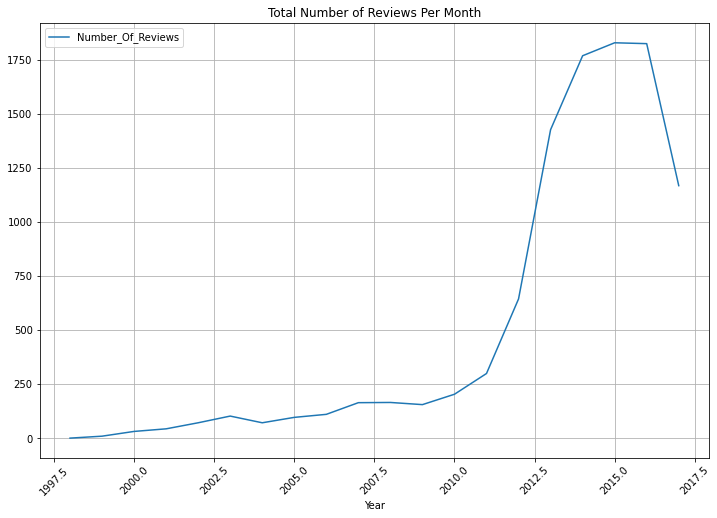

In [0]:
#Plot distribution of the number of reviews over the years
plt.rcParams["figure.figsize"] = (12,8)
Yearly.plot(x="Year",y="Number_Of_Reviews",kind="line",title="Total Number of Reviews Per Month")
plt.grid()
plt.xticks(rotation = 45)
plt.show()

In [0]:
#aggregate monthly reviews
Monthly = data.groupby(['Month'])['Reviewer_ID'].count().reset_index()

In [0]:
# Replacing digits of 'Month' column in 'Monthly' dataframe with words using 'Calendar' library
Monthly['Month'] = Monthly['Month'].apply(lambda x: calendar.month_name[x])
Monthly=Monthly.rename(columns={'Reviewer_ID':'Number_of_Reviews'})

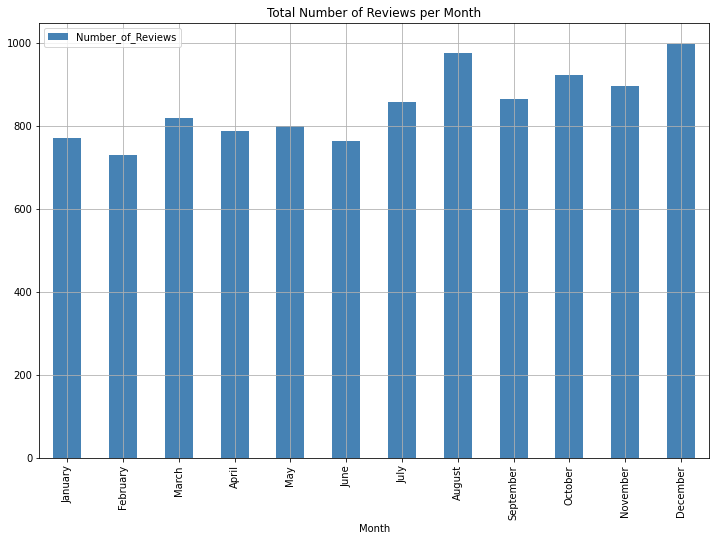

In [0]:
#Plot of the monthly number of reviews
plt.rcParams["figure.figsize"] = (12,8)
Monthly.plot(x="Month",y="Number_of_Reviews",kind="bar",title="Total Number of Reviews per Month", color = 'steelblue')
plt.grid()
plt.show()

In [0]:
#Convert rating to numeric
data.Rating = pd.to_numeric(data.Rating)

In [0]:
###Distribution of overall rating of products
AvgRatingProd = data.groupby('Asin')['Rating'].mean().reset_index()

In [0]:
result_AvgRatingProd=AvgRatingProd.groupby(pd.cut(AvgRatingProd.Rating,np.arange(0, 5.1, 1))).count()
result_AvgRatingProd=result_AvgRatingProd.rename(columns={'Rating':'Count'})
result_AvgRatingProd=result_AvgRatingProd.reset_index()

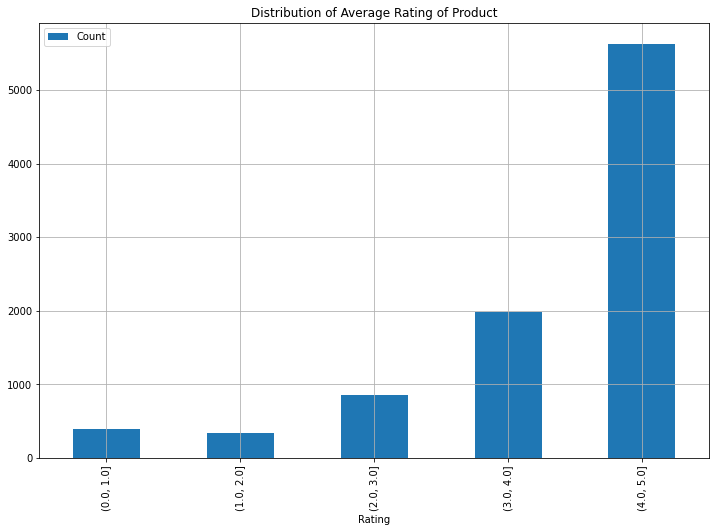

In [0]:
plt.rcParams["figure.figsize"] = (12,8)
fig = result_AvgRatingProd.plot(x="Rating",y="Count",kind="bar",title="Distribution of Average Rating of Product")
plt.grid()
plt.show()

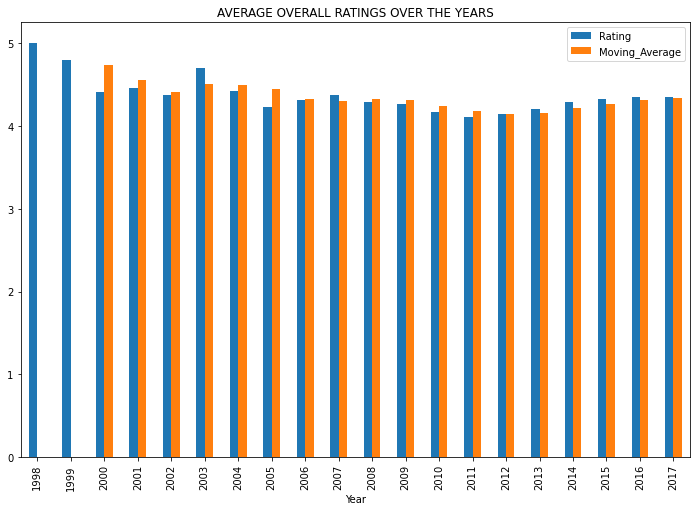

In [0]:
plt.rcParams["figure.figsize"] = (12,8)
#Generate yearly average
Yearly_Avg_Rating=data.groupby(['Year'])['Rating'].mean().reset_index()
#Compute movng average for the ratings
Yearly_Avg_Rating['Moving_Average']=Yearly_Avg_Rating['Rating'].rolling(window=3).mean()
Yearly_Avg_Rating.plot(x="Year",y=["Rating","Moving_Average"],kind="bar",title="AVERAGE OVERALL RATINGS OVER THE YEARS")
plt.show()

In [0]:
#### Average review length vs ratings
Avg_Review_Length = data[['Reviewer_ID','Asin','Reviewer_Name','Review_Text', "Rating"]]
# Get the word count
Avg_Review_Length['Word_Length']=Avg_Review_Length['Review_Text'].apply(lambda x: len(x.split()))
# get character count
Avg_Review_Length['Character_Length']=Avg_Review_Length['Review_Text'].apply(lambda x: len(x))
#Get average word length and character count
Review_Length_vs_Rating =Avg_Review_Length.groupby('Asin')['Character_Length','Word_Length', 'Rating'].mean().reset_index()
Review_Length_vs_Rating.head()

<command-2677371550004258>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 Avg_Review_Length['Word_Length']=Avg_Review_Length['Review_Text'].apply(lambda x: len(x.split()))
<command-2677371550004258>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 Avg_Review_Length['Character_Length']=Avg_Review_Length['Review_Text'].apply(lambda x: len(x))
<command-2677371550004258>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
 Review_Length_vs_Rating =Avg_Review_Length.groupby('Asin')['Character_Length','Word_Length', 'Rating'].mean().reset_index()
Out[46]:

,Asin,Character_Length,Word_Length,Rating
0,002710110X,185.0,37.0,5.0
1,006015716X,159.0,29.0,5.0
2,007128799X,52.0,11.0,4.0
3,007145148X,241.0,38.0,5.0
4,013351739X,149.0,25.0,4.0


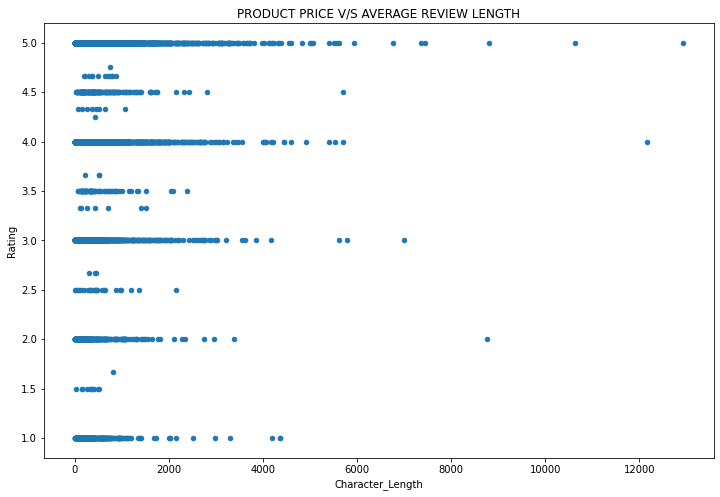

In [0]:
Review_Length_vs_Rating.plot(x="Character_Length",y="Rating",kind="scatter",title="PRODUCT PRICE V/S AVERAGE REVIEW LENGTH")
plt.show()

In [0]:
#Split data to train and test
#rename the target attribute (Rating)
df1 = df.withColumnRenamed("overall","label")
#Convert label to numeric
df1 = df1.withColumn("label", df1.label.cast('float'))
(train_set, val_set, test_set) = df1.randomSplit([0.70, 0.2, 0.1], seed = 100)

In [0]:
df1.columns

Out[75]: ['reviewID',
 'label',
 'verified',
 'reviewTime',
 'reviewerID',
 'asin',
 'reviewerName',
 'reviewText',
 'summary',
 'unixReviewTime']

In [0]:

from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="reviewText", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[tokenizer, hashtf, idf])

pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
val_df = pipelineFit.transform(val_set)
train_df.show(5)

+--------+-----+--------+-----------+--------------+----------+----------------+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+
reviewID|label|verified| reviewTime| reviewerID| asin| reviewerName| reviewText| summary|unixReviewTime| words| tf| features|
+--------+-----+--------+-----------+--------------+----------+----------------+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+
67000000| 3.0| TRUE|05 16, 2012|A3IXM075VM1P9T|B007JYB3O2| nachtik|I would say these...| average reading| 1337126400|[i, would, say, t...|(65536,[1109,5556...|(65536,[1109,5556...|
67000001| 5.0| TRUE|12 25, 2012|A3LGZ7A3WSV3JJ| 985719745| MSP|WOW, DROPPIN DIME...|WOW.................| 1356393600|[wow,, droppin, d...|(65536,[830,1880,...|(65536,[830,1880,...|
67000002| 5.0| TRUE|09 18, 2012|A3BF5G7CJNIAG0|B002KXH7PQ| C. S. DeMore|You'll love the p...|Another Buggy Bar...| 1347926400|[you'll, love, th...|(65536,[1880,6693...|(65536,[1880,6693...|
67000004| 5.0| FALSE|03 29, 2003| ACTBQZV1CJ9E8|9706061681|Richard Eastwood|MI MEJOR AMIGO..Q...|LE ACABA DE SUCED...| 1048896000|[mi, mejor, amigo...|(65536,[388,2719,...|(65536,[388,2719,...|
67000005| 5.0| TRUE|04 22, 2014|A1RL0VMJVV8Q9N|B00BDAIDQ4| Barbara270|This is a short s...| Beautifully Written| 1398124800|[this, is, a, sho...|(65536,[1960,3085...|(65536,[1960,3085...|
+--------+-----+--------+-----------+--------------+----------+----------------+--------------------+--------------------+--------------+--------------------+--------------------+--------------------+
only showing top 5 rows

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
lr = LogisticRegression(maxIter=100)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(val_df)
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
evaluator.evaluate(predictions)

Out[98]: 0.5504313523204105

In [0]:
#Overview of the predictions
predictions.filter(predictions['prediction'] != 0) \
    .select("label","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

In [0]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes()
model = nb.fit(train_df)
predictions = model.transform(val_df)
#Overview of the predictions
predictions.filter(predictions['prediction'] == 0) \
    .select("label","probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+-----+------------------------------+-----+----------+
label| probability|label|prediction|
+-----+------------------------------+-----+----------+
 1.0|[1.0,1.6368001834798885E-21...| 1.0| 0.0|
 1.0|[0.9999381024367586,5.47516...| 1.0| 0.0|
 1.0|[0.9906794207502158,3.74952...| 1.0| 0.0|
 5.0|[0.9849772724951864,8.04214...| 5.0| 0.0|
 1.0|[0.9811248203701556,2.65725...| 1.0| 0.0|
 1.0|[0.9722843636789852,2.21886...| 1.0| 0.0|
 1.0|[0.9587656457538692,1.24335...| 1.0| 0.0|
 1.0|[0.9071034994078899,3.32378...| 1.0| 0.0|
 4.0|[0.9024761201464939,0.00226...| 4.0| 0.0|
 1.0|[0.8788726748302679,1.15191...| 1.0| 0.0|
+-----+------------------------------+-----+----------+
only showing top 10 rows

In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

Out[88]: 0.09229940934120243

In [0]:
from pyspark.ml.classification import RandomForestClassifier
#Define random forest model
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="features")
# Train random forest model with Training Data
rfModel = rf.fit(train_df)


In [0]:
#Generate predictions using the model
predictions = rfModel.transform(val_df)
predictions.filter(predictions['prediction'] == 5) \
    .select("probability","label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 30)

+------------------------------+-----+----------+
 probability|label|prediction|
+------------------------------+-----+----------+
[0.0,0.12571646374763526,0....| 1.0| 5.0|
[0.0,0.09234791184058717,0....| 4.0| 5.0|
[0.0,0.09112758495542898,0....| 4.0| 5.0|
[0.0,0.09031719137323227,0....| 5.0| 5.0|
[0.0,0.08244639106146633,0....| 3.0| 5.0|
[0.0,0.082078377239468,0.03...| 4.0| 5.0|
[0.0,0.0815832787553415,0.0...| 2.0| 5.0|
[0.0,0.0809732696311219,0.0...| 2.0| 5.0|
[0.0,0.08087355274205996,0....| 5.0| 5.0|
[0.0,0.08031926473336506,0....| 4.0| 5.0|
+------------------------------+-----+----------+
only showing top 10 rows

In [0]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
evaluator.evaluate(predictions)

Out[97]: 0.4631997899585885